Using the fact that in the case of a naive Bayes classifier for a two-dimensional vector of observations x=(x, y)

p(X|1)=p(x|1)*p(y|1)

assuming that the probability density of each class is described by a Gaussian distribution, demonstrate graphically the equivalence between this approach and the results obtained using the DecisionBoundaryDisplay.from_estimator() function

In [1]:
# importing libraries
from sklearn.naive_bayes import GaussianNB
from sklearn.inspection import DecisionBoundaryDisplay

from scipy.stats import norm
from scipy.stats import multivariate_normal as mvnorm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
#create data from two classes
def create_data(n1, n2, m1, m2, S1, S2):

    data1 = np.random.multivariate_normal(m1, S1, n1)
    data2 = np.random.multivariate_normal(m2, S2, n2)

    data = np.concatenate((data1, data2), axis = 0)
    data = pd.DataFrame(data, columns=["x", "y"])

    data["group"] = np.repeat([0, 1], [n1, n2])
    
    return data

m1, m2 = [-3, -1], [2, 2] #mean
S1 = [[4, 0], [0, 4]] #covariance matrix
S2 = S1
n1, n2 = 40, 30 #number of points

data = create_data(n1, n2, m1, m2, S1, S2)
data

,x,y,group
0,0.788186,0.148423,0
1,-2.176577,-2.501316,0
2,-5.840340,-1.879359,0
3,-4.699199,-0.637758,0
4,-4.470220,-4.937496,0
...,...,...,...
65,4.342543,2.807712,1
66,4.147786,3.155805,1
67,2.883882,2.558830,1
68,3.275515,3.136733,1


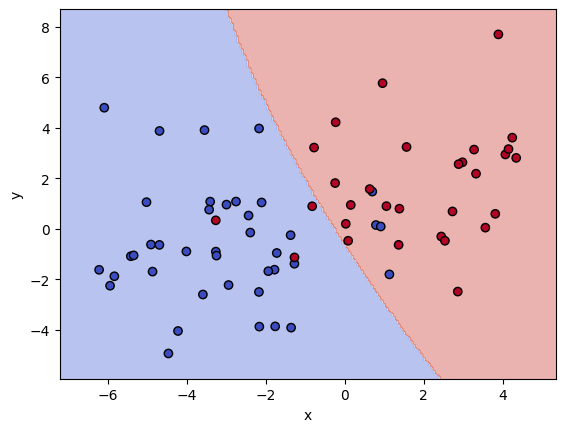

In [27]:
#naive bayess classifier
nb = GaussianNB()
nb.fit(data[["x","y"]], data.group)

data_comp = pd.DataFrame({'org': data.group, 'pred': nb.predict(data[["x","y"]])})

#show estimated class boundary
disp = DecisionBoundaryDisplay.from_estimator(nb, data[["x","y"]], response_method="predict", 
                                                alpha=0.4, cmap=plt.cm.coolwarm, grid_resolution=200)
                                     
plt.scatter(data.x, data.y, c=data["group"], edgecolor="k", cmap=plt.cm.coolwarm)
                                    
plt.show()

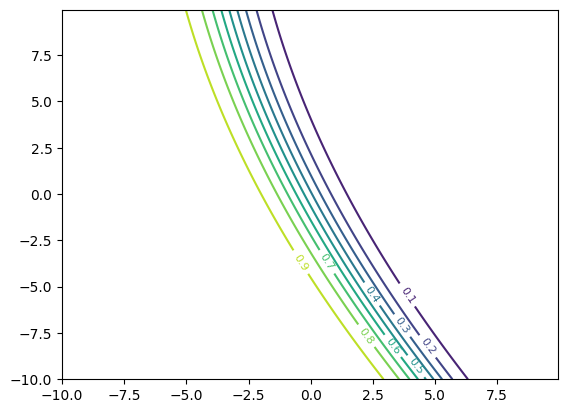

In [40]:
x, y = np.mgrid[-10:10:.05, -10:10:.05]
data_grid = pd.DataFrame({'x': x.ravel(), 'y': y.ravel()})

Z = nb.predict_proba(data_grid)[:,0].reshape(x.shape)

contours = plt.contour(x, y, Z,10)
plt.clabel(contours, inline=True, fontsize=8)

plt.show()

I'm using Bayes Theorem:
$$ p(k|X) = \frac{\pi _k p(X|k)}{\sum _{r=1} ^ {g} \pi _r p(X|r)} $$
where 
$p(X|k)$ is the density function of X that comes for kth class
$\pi _k$ is the overall (or prior) probability that a randomly chosen
observation comes from kth class



naive assumption: x and y are independent
$$ p(X|1)=p(x|1)*p(y|1) $$



my final equation for 2 classes is
$$ p(0|X) = \frac{\pi _0 * p(x|0)*p(y|0)}{\pi _0* p(x|0)*p(y|0) + \pi _1 *p(x|1)*p(y|1)}  $$


In [ ]:
#create my own version of DecisionBoundaryDisplay based on math behing NB classifier 
def own_nb(X, pi0, pi1, mh, sh):
  n0x=norm.pdf(X["x"], mh.loc[0]['x'], sh.loc[0]['x'])
  n0y=norm.pdf(X["y"], mh.loc[0]['y'], sh.loc[0]['y'])
  n1x=norm.pdf(X["x"], mh.loc[1]['x'], sh.loc[1]['x'])
  n1y=norm.pdf(X["y"], mh.loc[1]['y'], sh.loc[1]['y'])

  return pi0*n0x*n0y/(pi0 * n0x*n0y + pi1 * n1x*n1y)

X=data[["x", "y"]]

mh = data.groupby("group").mean()
sh = data.groupby("group").std()

nn = n1 + n2
pi0=n1/nn
pi1=n2/nn


data_comp["pred_own"] = np.round(own_nb(X, pi0, pi1, mh, sh), 4)

In [68]:
data_comp

,org,pred,pred_own
0,0,1,0.2016
1,0,0,0.9749
2,0,0,0.9996
3,0,0,0.9968
4,0,0,0.9996
...,...,...,...
65,1,1,0.0009
66,1,1,0.0009
67,1,1,0.0060
68,1,1,0.0029


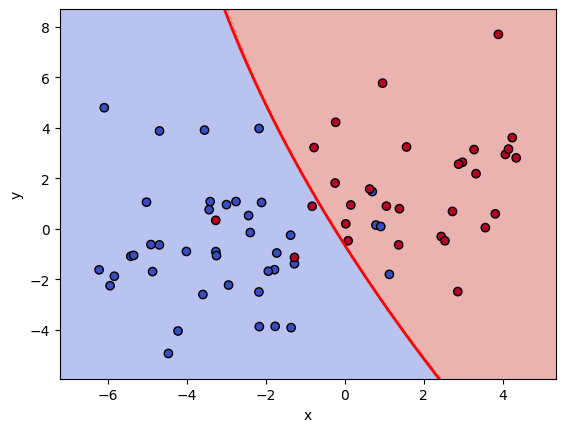

In [ ]:
ZNb = own_nb(data_grid[["x","y"]],pi1, pi2, mh, sh).reshape(x.shape)

disp = DecisionBoundaryDisplay.from_estimator(nb, data[["x","y"]], response_method="predict", 
                                              alpha=0.4, cmap=plt.cm.coolwarm, grid_resolution=200)
                                              
xmin, xmax = disp.ax_.get_xlim()
ymin, ymax = disp.ax_.get_ylim()

plt.scatter(data.x, data.y, c=data["group"], edgecolor="k", cmap=plt.cm.coolwarm)
plt.contour(x, y, ZNb, [0.5],  linewidths=2.0, colors="red")

disp.ax_.set_xlim((xmin, xmax));
disp.ax_.set_ylim((ymin, ymax));

plt.show()